In [8]:
import librosa
import numpy as np
import os
import sys
import parselmouth
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
def analyze_audio(file_path):
    try:
        snd = parselmouth.Sound(file_path)
        pitch = snd.to_pitch()
        pitch_values = pitch.selected_array["frequency"]
        pitch_values = pitch_values[pitch_values > 0]  
        
        mean_pitch = np.mean(pitch_values) if len(pitch_values) > 0 else None
        min_pitch = np.min(pitch_values) if len(pitch_values) > 0 else None
        max_pitch = np.max(pitch_values) if len(pitch_values) > 0 else None
        std_pitch = np.std(pitch_values) if len(pitch_values) > 0 else None
        intensity = snd.to_intensity()
        mean_intensity = np.mean(intensity.values.T)
        duration = snd.get_total_duration()

        y, sr = librosa.load(file_path, sr=None)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
        rms = np.mean(librosa.feature.rms(y=y))
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)  

        return {
            "file_name": os.path.basename(file_path),
            "mean_pitch": mean_pitch,
            "min_pitch": min_pitch,
            "max_pitch": max_pitch,
            "std_pitch": std_pitch,
            "mean_intensity": mean_intensity,
            "duration": duration,
            "tempo": tempo[0],
            "spectral_centroid": spectral_centroid,
            "spectral_bandwidth": spectral_bandwidth,
            "zcr": zcr,
            "rms": rms,
            **{f"mfcc_{i+1}": mfcc for i, mfcc in enumerate(mfccs)}
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [11]:
def process_folder(folder_path):
    results = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            analysis_result = analyze_audio(file_path)
            if analysis_result:
                results.append(analysis_result)
    df = pd.DataFrame(results)
    return df


In [12]:
folder_path = "data/audio_data"  

df = process_folder(folder_path)

df.head()

Error processing data/audio_data\1076_MTI_SAD_XX.wav: 'float' object is not subscriptable


,file_name,mean_pitch,min_pitch,max_pitch,std_pitch,mean_intensity,duration,tempo,spectral_centroid,spectral_bandwidth,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,1001_DFA_ANG_XX.wav,162.475491,96.097781,513.709087,78.998671,57.550544,2.275562,133.928571,1584.993070,1797.090279,...,0.408197,-9.709486,-6.127124,1.737389,-14.560825,-5.176119,-2.429939,-8.718916,-6.897351,-7.056198
1,1001_DFA_DIS_XX.wav,239.162029,75.387546,583.754741,170.907891,53.599781,2.335688,98.684211,1531.650487,1794.059344,...,-2.534367,-7.255390,-6.153906,-3.609860,-12.719008,-3.148828,-3.569027,-8.540991,-7.949693,-3.837131
2,1001_DFA_FEA_XX.wav,204.203676,154.863491,234.670773,20.241356,56.249986,2.168813,133.928571,1489.088839,1802.553434,...,-3.357414,-8.454173,-6.561941,-2.693144,-11.711654,-5.718830,-4.945804,-8.096901,-8.022044,-6.047218
3,1001_DFA_HAP_XX.wav,194.418705,117.662971,506.003016,89.157365,57.708380,1.868500,117.187500,1555.376035,1808.267005,...,-0.201025,-8.867324,-9.357766,-0.485934,-13.141247,-5.608707,-3.212478,-8.372482,-6.299030,-3.303278
4,1001_DFA_NEU_XX.wav,138.486189,75.838761,234.789456,38.830498,54.641066,2.035375,156.250000,1495.394997,1772.570383,...,1.537680,-9.795646,-3.472060,0.390186,-12.495291,-4.637795,-4.421584,-5.515663,-7.480078,-5.786465


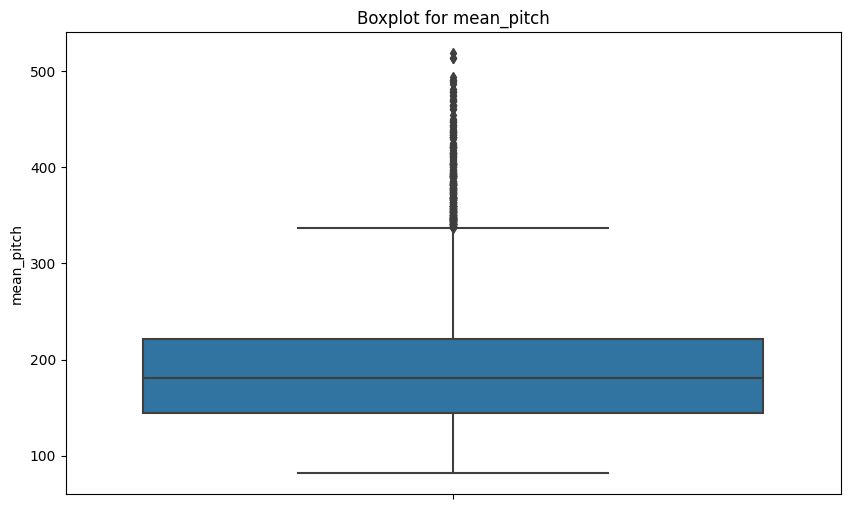

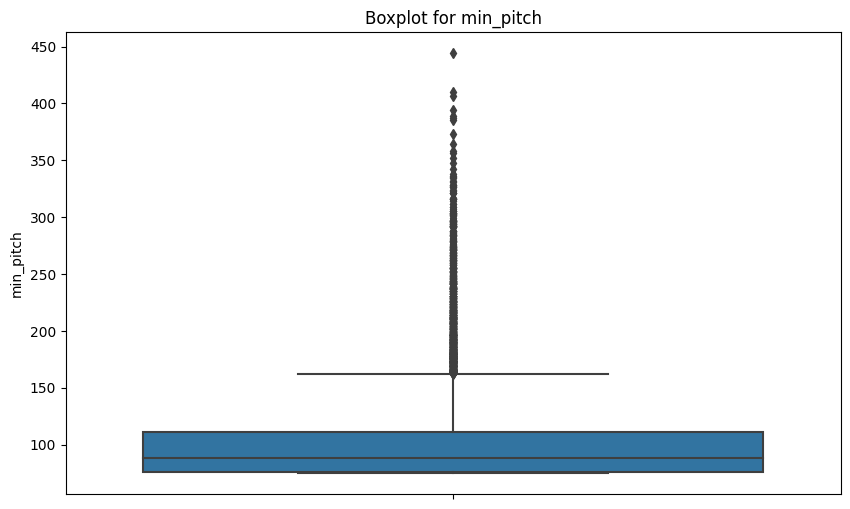

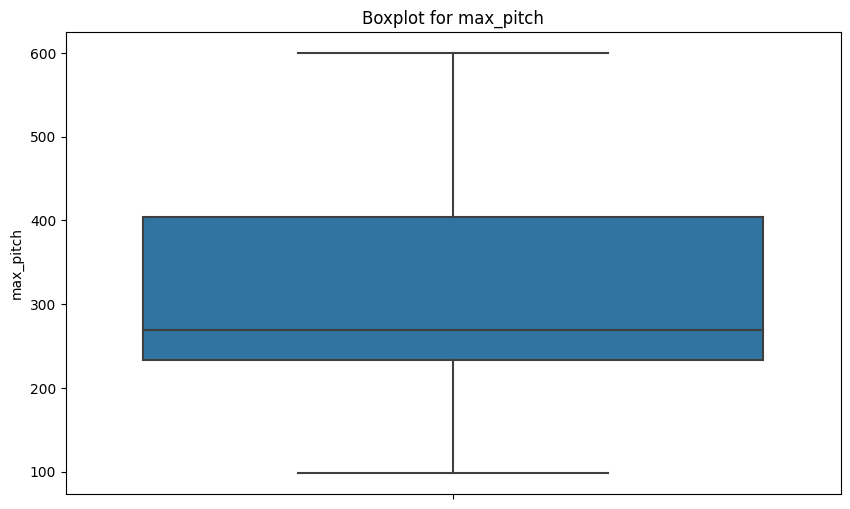

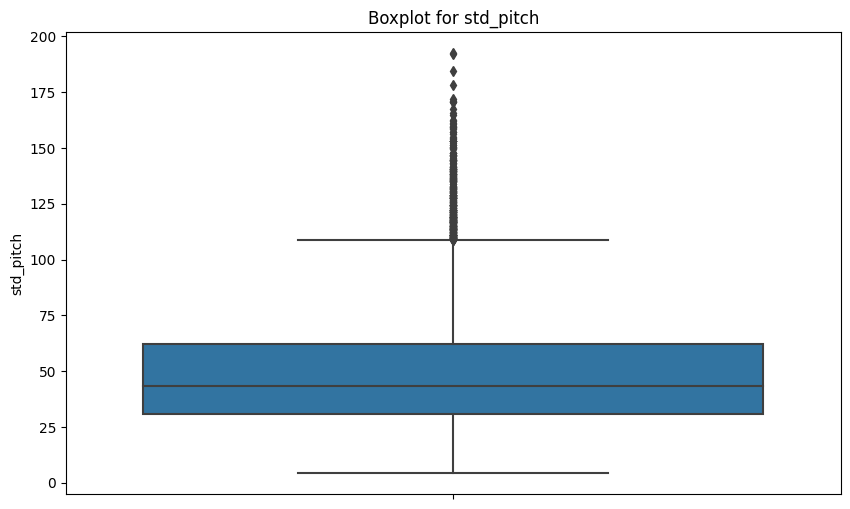

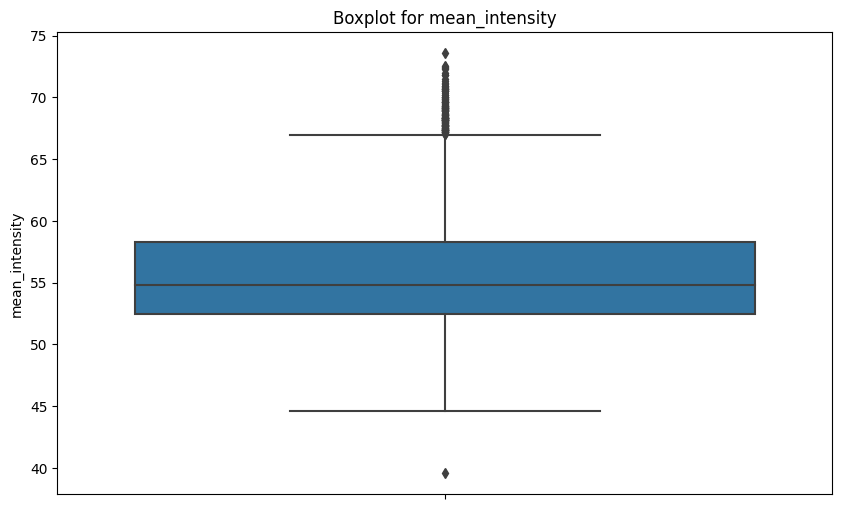

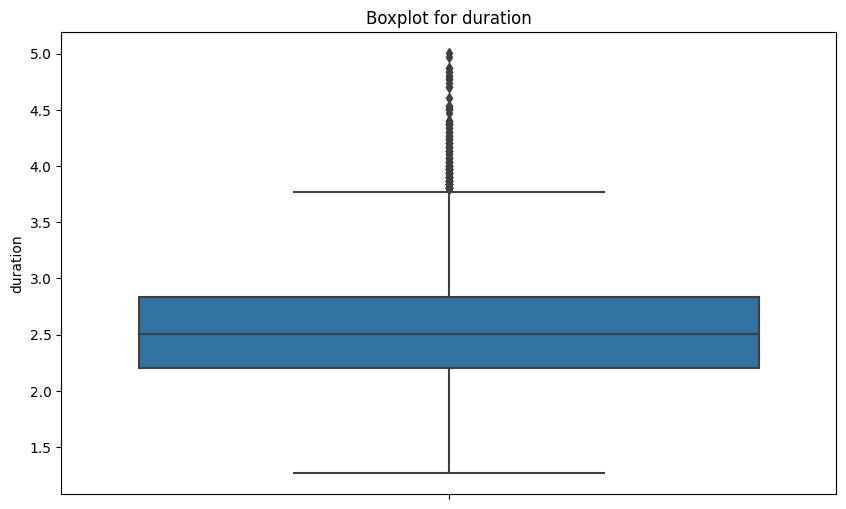

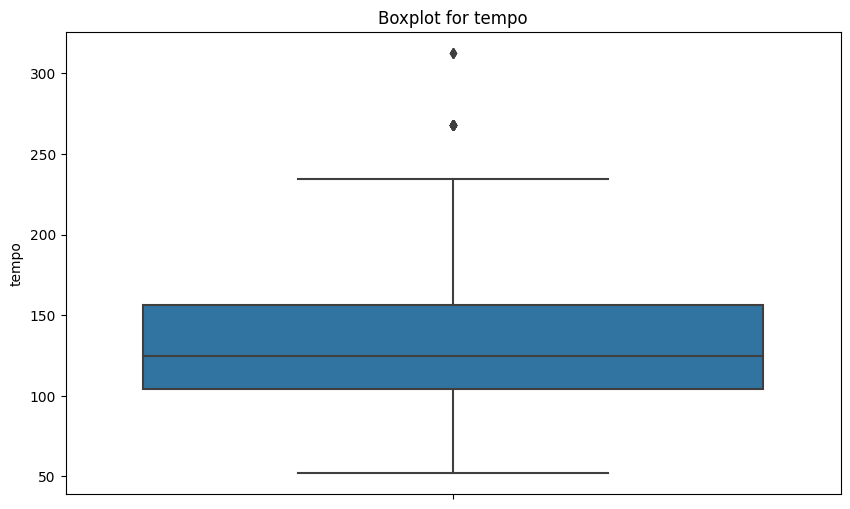

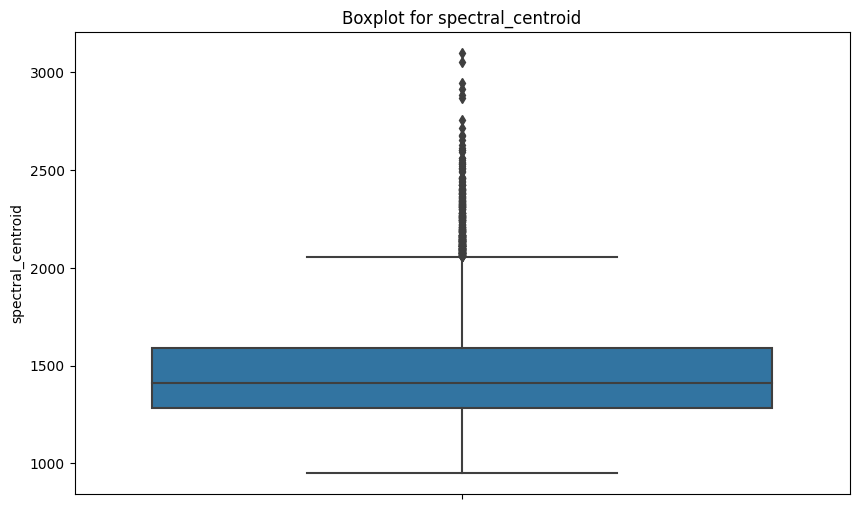

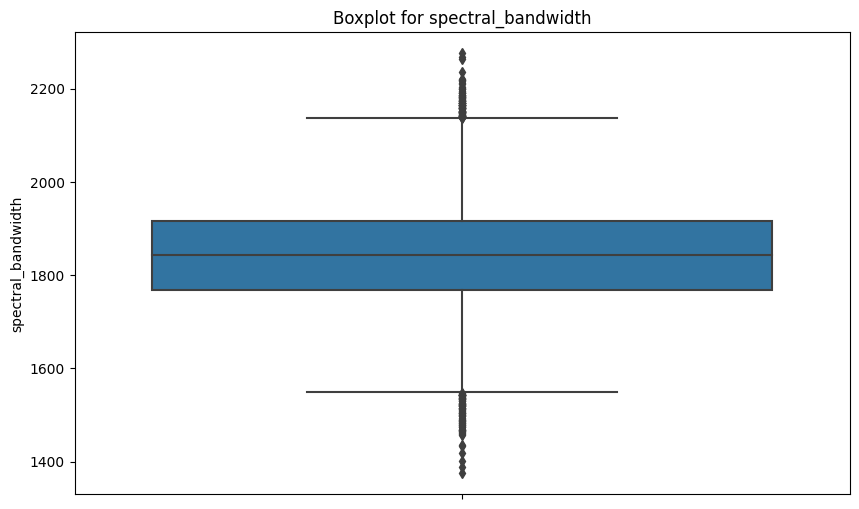

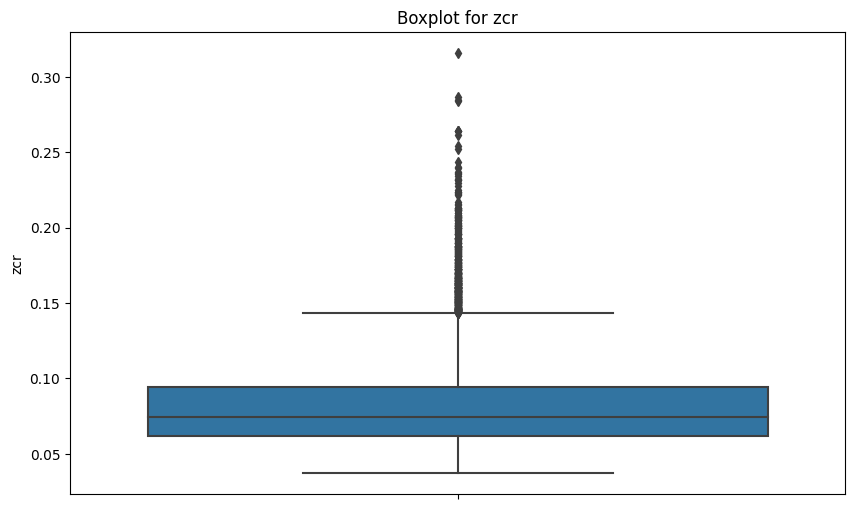

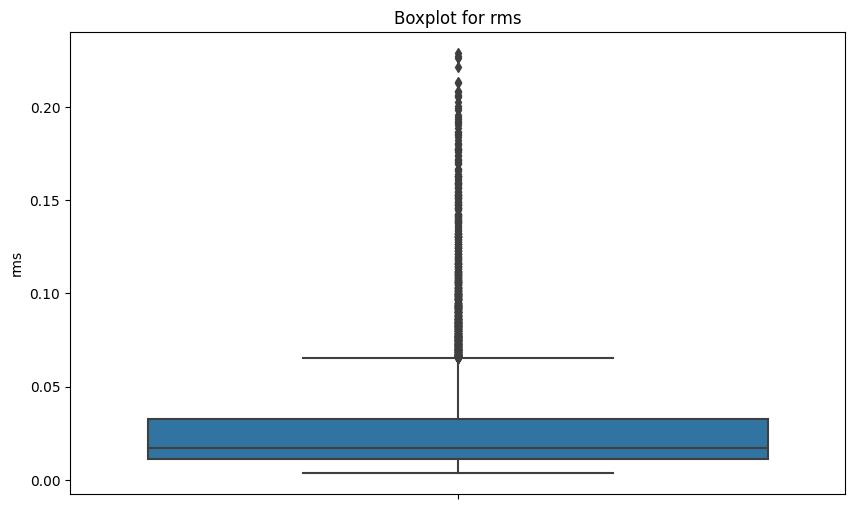

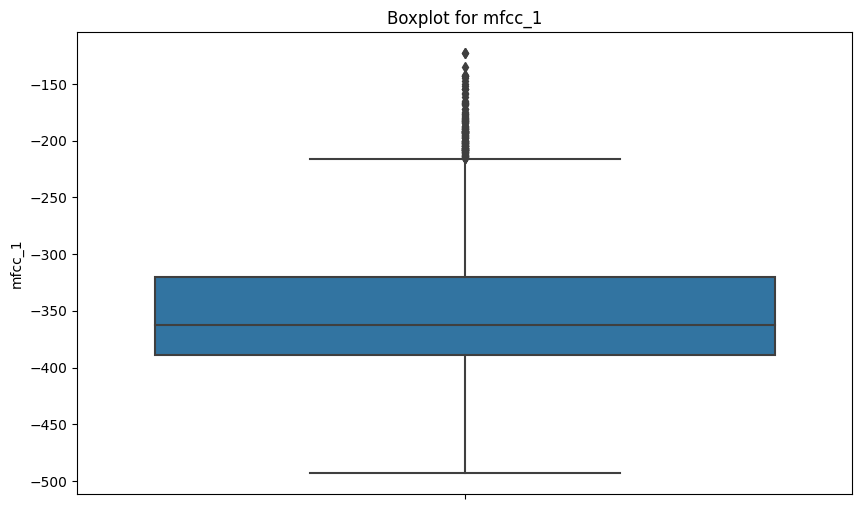

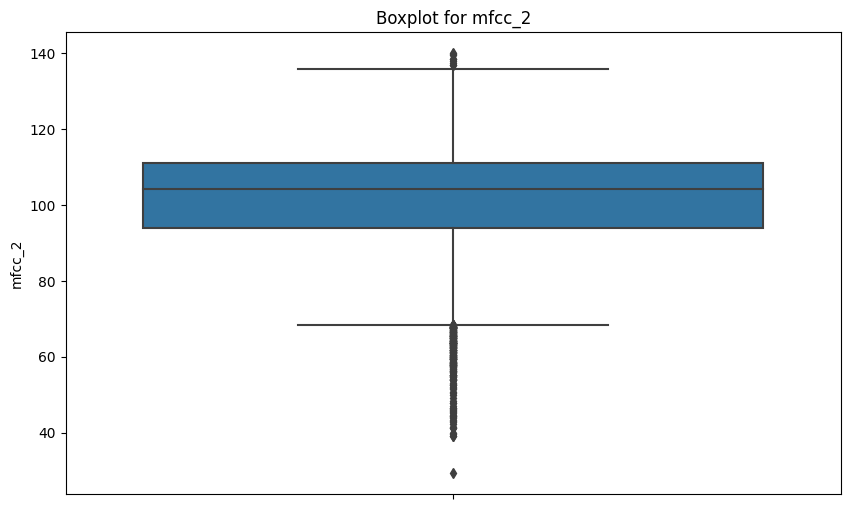

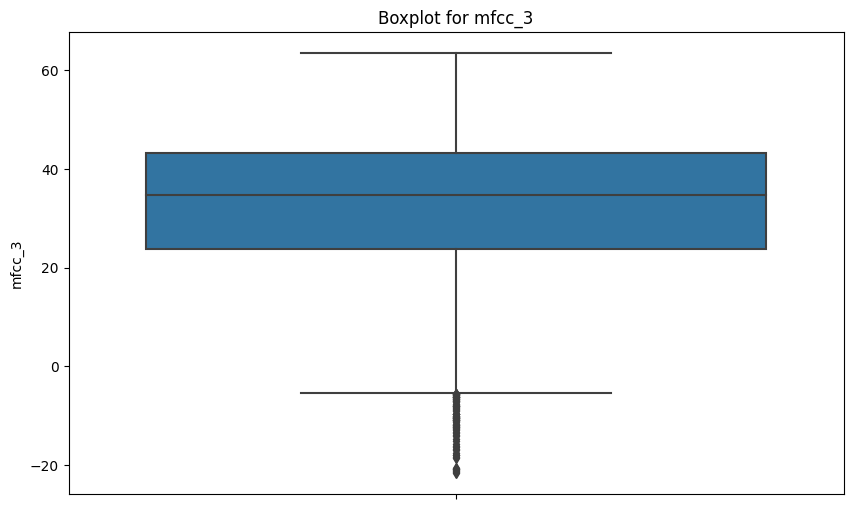

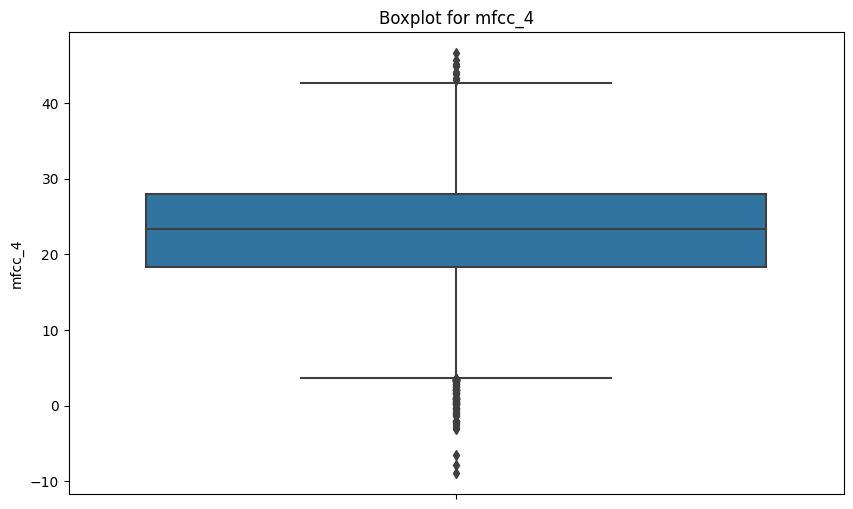

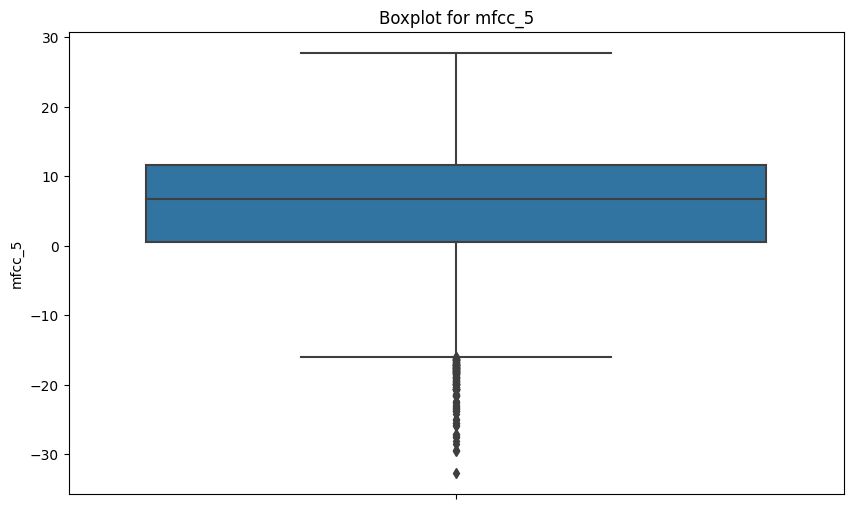

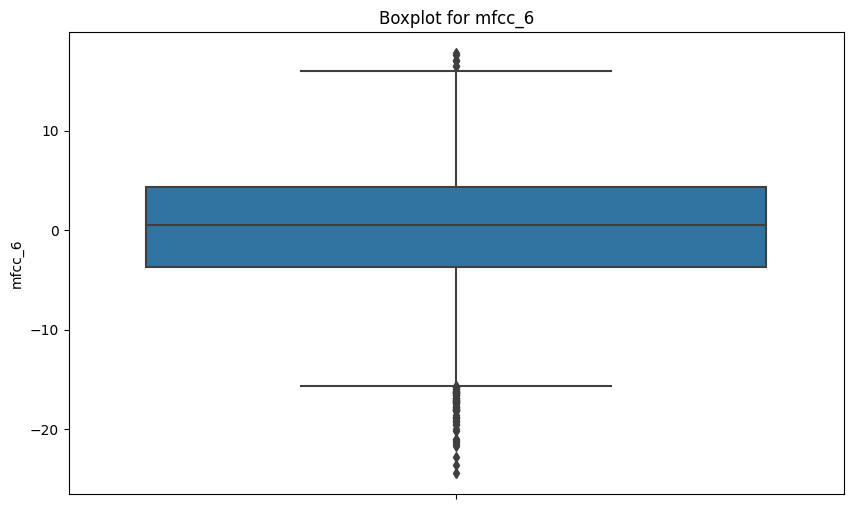

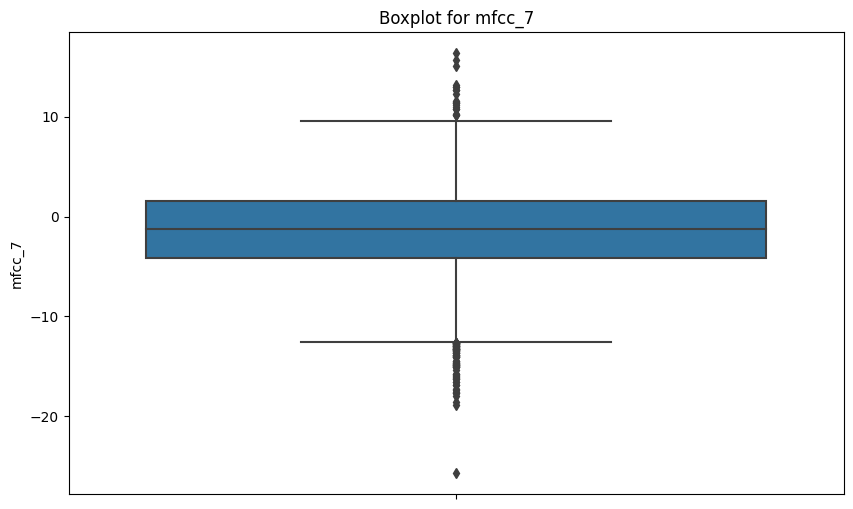

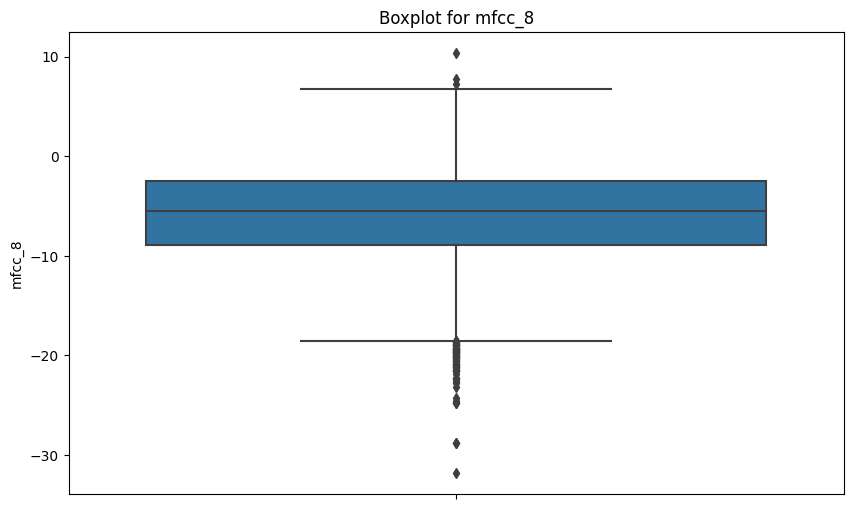

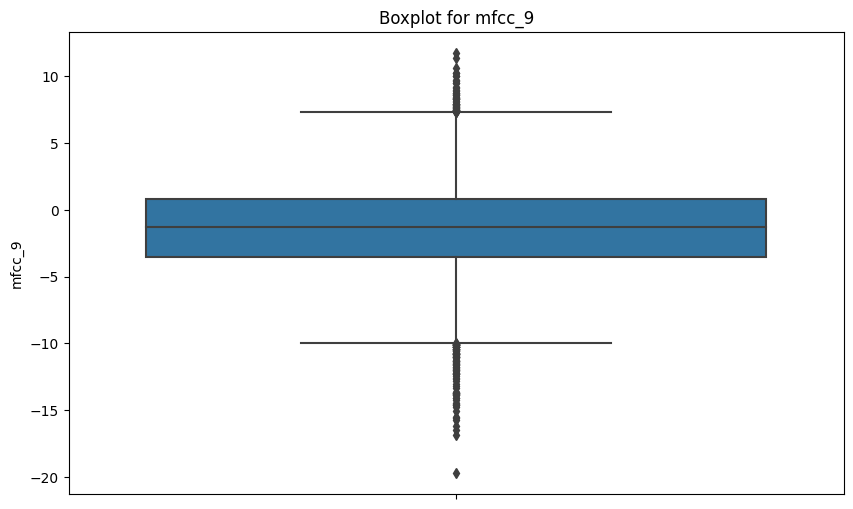

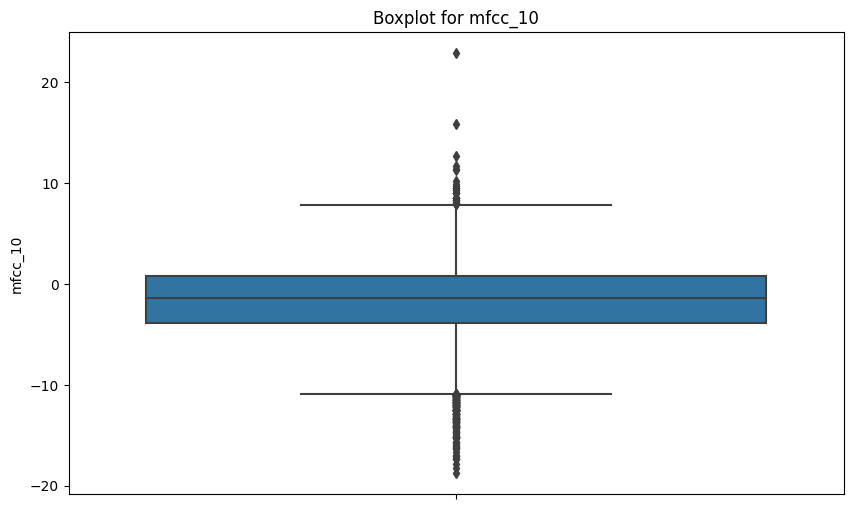

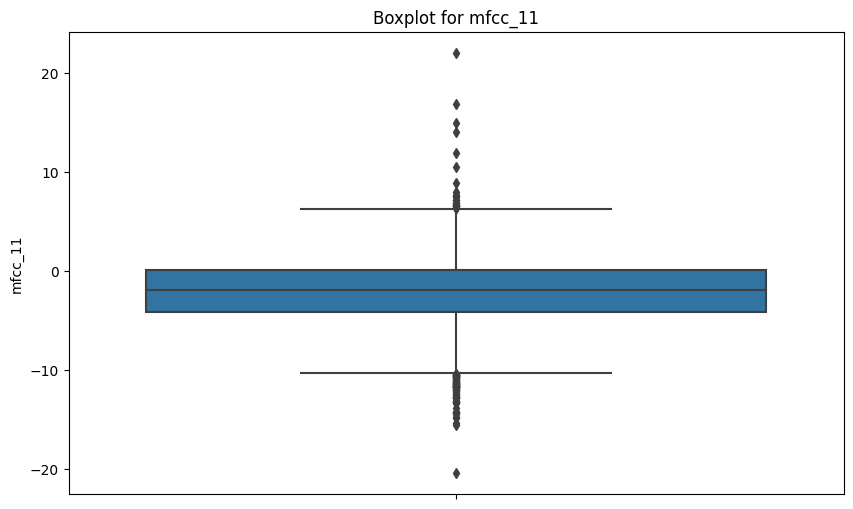

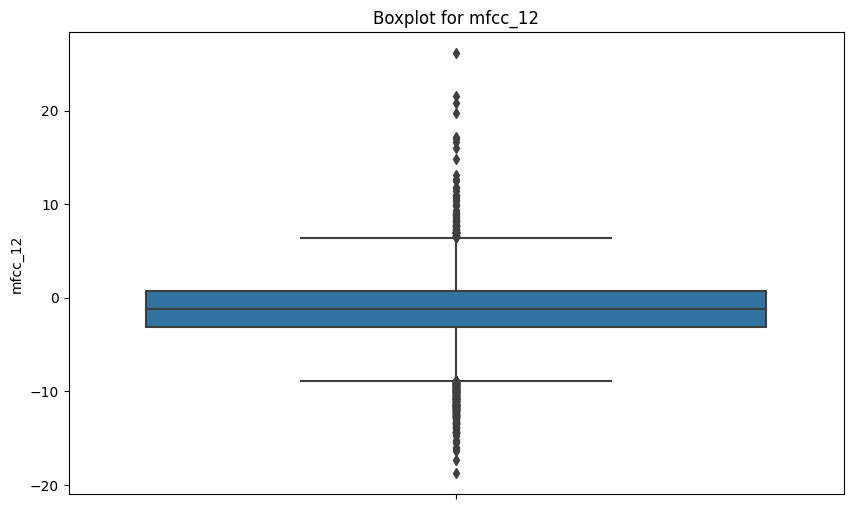

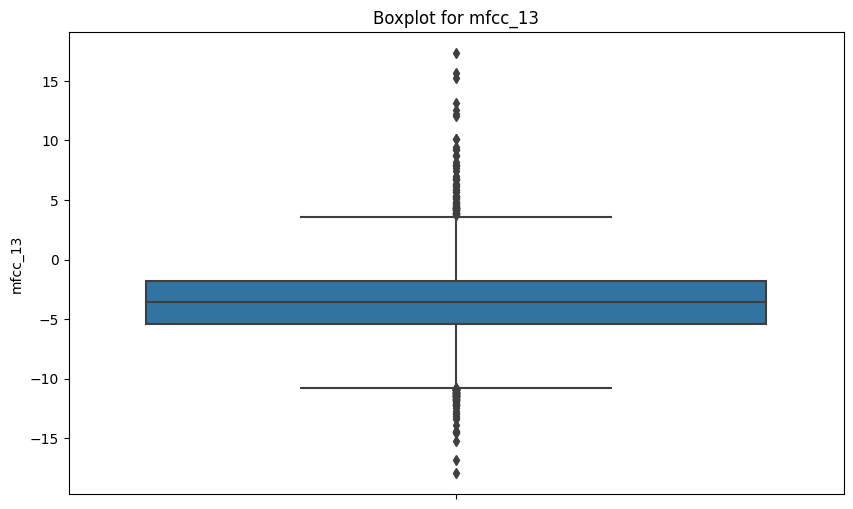

In [13]:
def plot_boxplots(df, features):
    for feature in features:
        if feature in df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=df, y=feature)
            plt.title(f"Boxplot for {feature}")
            plt.ylabel(feature)
            plt.show()

features = [
    "mean_pitch", "min_pitch", "max_pitch", "std_pitch",
    "mean_intensity", "duration", "tempo",
    "spectral_centroid", "spectral_bandwidth",
    "zcr", "rms"
] + [f"mfcc_{i+1}" for i in range(13)]  


plot_boxplots(df, features)

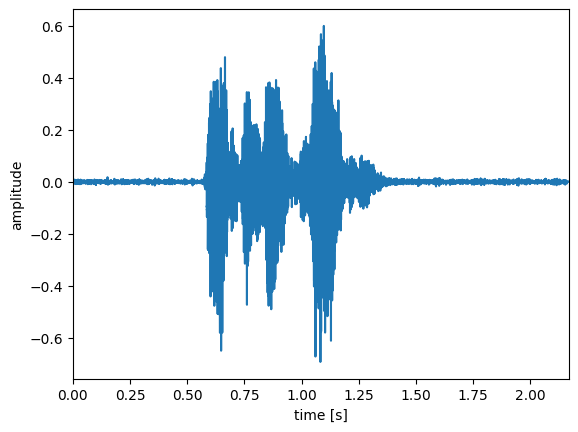

In [16]:
snd = parselmouth.Sound(r"data/audio_data\1001_DFA_FEA_XX.wav")
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

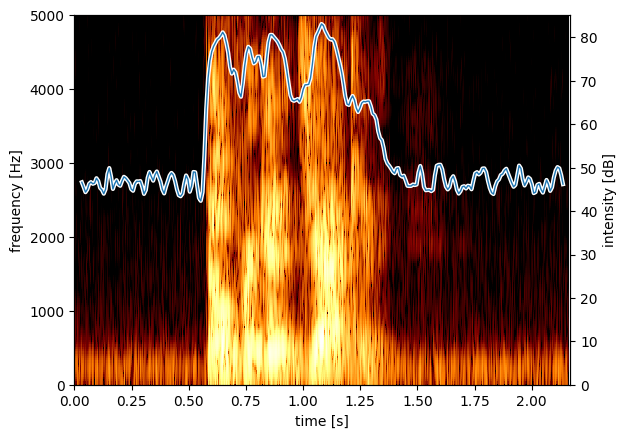

In [17]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

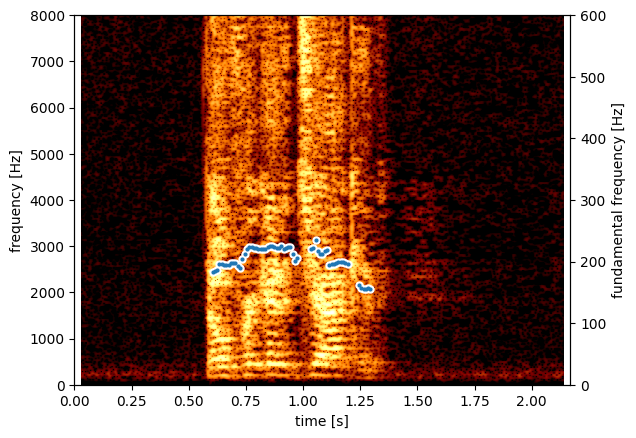

In [18]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()